In [9]:
%load_ext autoreload
%autoreload 2

In [10]:
import sys
sys.path.append("../scripts")

In [11]:
# Main
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import utils

# Modelling
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import pmdarima as pm
from fbprophet import Prophet
pd.plotting.register_matplotlib_converters()

In [12]:
plt.rcParams["figure.figsize"] = (14,4)

In [13]:
data = pd.read_csv("../data/base_limpia.csv", parse_dates=["tiempo", "fecha pedido", "fecha liq"])

In [14]:
data.head()

,tiempo,nro factura,cliente,categoria,tipo negocio,localidad,direccion,plaza/campaña,producto,nro pedido,...,u pedidas,kg pedidos,fecha liq,u entregadas,kg entregados,importe bruto,importe factura,sucursal,longitud,latitud
0,2017-05-29,93315173,200008870,a5,mayorista,santa fe,av del valle 7199,plaza,90746,2736812,...,1,1.250,2017-05-29,1,1.250,231.70,12421.88,santa fe,-60.691979,-31.602638
1,2017-06-14,93368453,200008870,a5,mayorista,santa fe,av del valle 7199,plaza,90746,2765668,...,1,1.250,2017-06-14,1,1.250,231.70,19944.84,santa fe,-60.691979,-31.602638
2,2017-02-21,93074208,200008889,a3,supermercado,santa fe,gral.paz 5374,plaza,90740,2546672,...,2,1.464,2017-02-21,2,1.464,324.96,24534.07,santa fe,-60.686356,-31.620964
3,2017-05-11,93270490,200008889,a3,supermercado,santa fe,gral.paz 5374,plaza,90746,2702464,...,1,1.250,2017-05-11,1,1.250,231.70,27204.63,santa fe,-60.686356,-31.620964
4,2017-05-24,93309184,200008889,a3,supermercado,santa fe,gral.paz 5374,plaza,90746,2732609,...,1,1.250,2017-05-24,1,1.250,231.70,16573.12,santa fe,-60.686356,-31.620964


In [15]:
u_producto = pd.pivot_table(
    data, 
    values="u pedidas", 
    index="tiempo", 
    columns="producto", 
    aggfunc="sum").asfreq("D")

In [16]:
u_producto.head()

producto,16034,16061,16062,16070,16071,16075,16076,16077,16080,16081,...,44151,44152,44154,44155,44157,44158,90739,90740,90745,90746
tiempo,,,,,,,,,,,,,,,,,,,,,
2017-01-02,NaN,7.0,1.0,25.0,11.0,3.0,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,1.0,NaN,NaN,4.0,1.0,NaN,NaN
2017-01-03,NaN,21.0,NaN,27.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,NaN,NaN
2017-01-04,NaN,NaN,NaN,8.0,4.0,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
2017-01-05,NaN,3.0,NaN,6.0,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10.0,NaN,1.0,NaN,1.0,NaN,NaN
2017-01-06,NaN,NaN,2.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


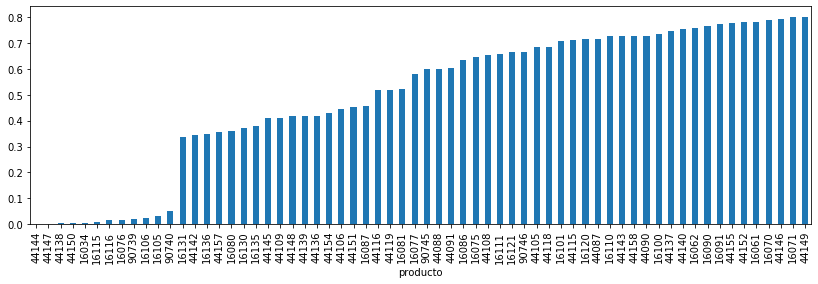

In [19]:
amount_info = utils.get_amount_info(u_producto)
amount_info.plot(kind="bar")

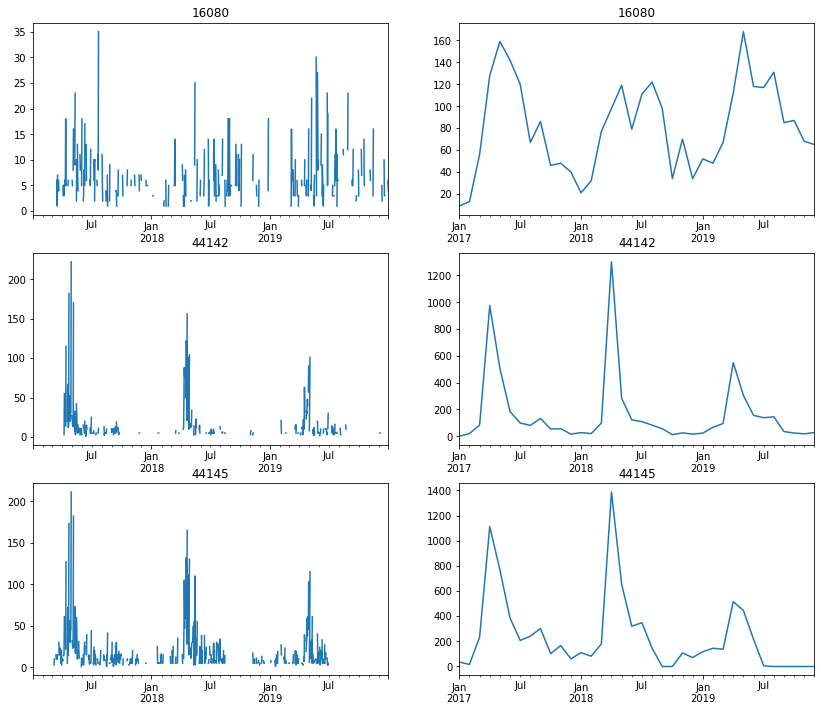

In [138]:
items = [16080, 44142, 44145]
f, ax = plt.subplots(3, 2, figsize=(14, 3*4))
for k, item in enumerate(items):
    u_producto[item].plot(ax=ax[k, 0], title=item)
    ax[k, 0].set_xlabel("")
    u_producto[item].resample("M").sum().plot(ax=ax[k, 1], title=item)
    ax[k, 1].set_xlabel("")

In [25]:
u_producto_forecastable = utils.get_forecastables(u_producto, T=0.5, N=4)

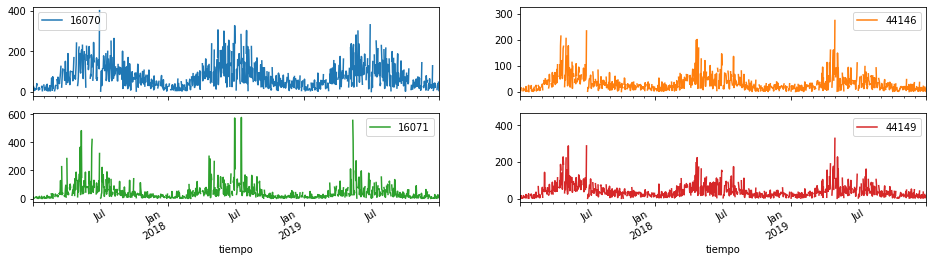

In [26]:
utils.plot_grid(u_producto_forecastable, n_cols=2, figsize=(16, 4))

In [27]:
train, test = u_producto_forecastable[:"2018-12-31"].copy(), u_producto_forecastable["2019-01-01":].copy()

# Monthly Forecast

In [30]:
item = 44149
y_train = train[item].resample("M").sum()
y_test = test[item].resample("M").sum()

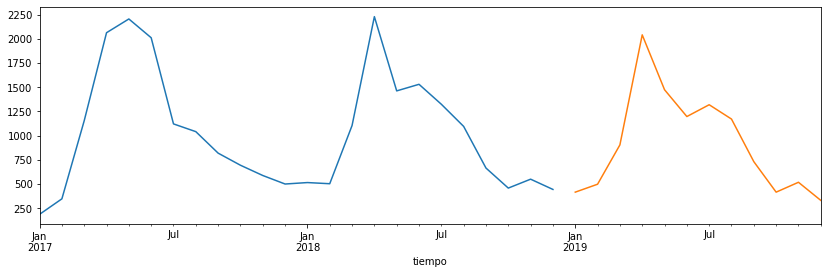

In [33]:
y_train.plot()
y_test.plot()

In [43]:
y_train_copy = y_train.copy()
y_train_copy.index = pd.date_range(start="2015-01-01", end="2016-12-31", freq="M")
y_train = pd.concat([y_train_copy, y_train])
y_train.index.name = "ds"
y_train.name = "y"

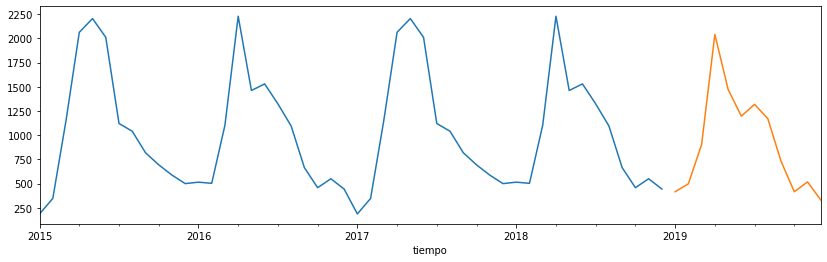

In [46]:
y_train.plot()
y_test.plot()

In [47]:
model_prophet = Prophet(
    yearly_seasonality=True, 
    weekly_seasonality=False, 
    daily_seasonality=False)
model_prophet.fit(y_train.reset_index())
future = model_prophet.make_future_dataframe(periods=12, freq="M")
fcst = model_prophet.predict(future)
fcst = fcst[["ds", "yhat", "yhat_lower", "yhat_upper"]].set_index("ds")

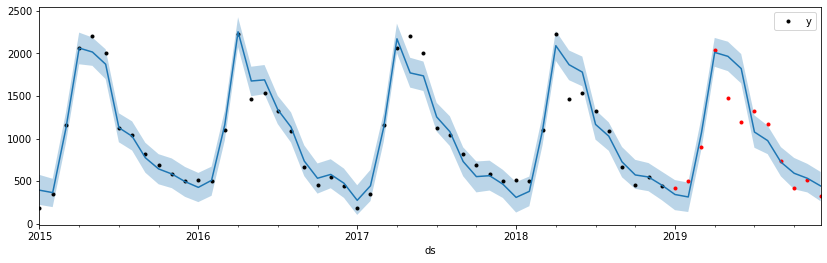

In [69]:
utils.plot_fcst(fcst, train=y_train, test=y_test)

In [71]:
model_arima = pm.auto_arima(y_train, seasonal=True, m=12, maxiter=100, suppress_warnings=True)

C:\Users\ariel\Anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\ariel\Anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:994: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

C:\Users\ariel\Anaconda3\envs\ml\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ariel\Anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\ariel\Anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning:

Too few observations to estimate starting param

In [105]:
pred = model_arima.predict_in_sample(start=12, end=59, return_conf_int=True)

In [106]:
fcst = pd.DataFrame(
    {"yhat":pred[0], "yhat_lower":pred[1][:,0], "yhat_upper":pred[1][:,1]}, 
    index=pd.date_range(start="2016-01-01", end="2019-12-31", freq="M"))

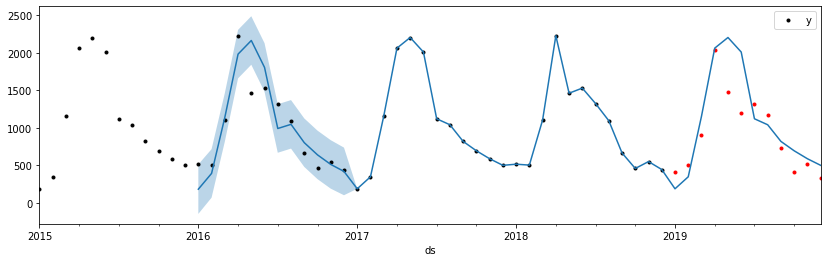

In [107]:
utils.plot_fcst(fcst, y_train, y_test)

In [143]:
train_m = train.resample("M").sum()
test_m = test.resample("M").sum()

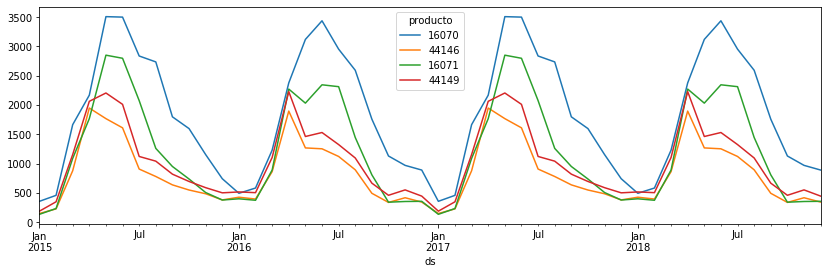

In [148]:
train_m.plot()

In [145]:
train_m_copy = train_m.copy()
train_m_copy.index = pd.date_range(start="2015-01-01", end="2016-12-31", freq="M")
train_m = pd.concat([train_m_copy, train_m])
train_m.index.name = "ds"
train_m.name = "y"

In [150]:
from forecaster import ProphetForecaster

In [152]:
model_prophet = ProphetForecaster(
    use_boxcox=False,
    yearly_seasonality=True,)

In [154]:
model_prophet.fit(train_m)

Fitting...


4 of 4|###################################################################|100%


{16070: <fbprophet.forecaster.Prophet at 0x2cb4aa1ab08>,
 44146: <fbprophet.forecaster.Prophet at 0x2cb39e03608>,
 16071: <fbprophet.forecaster.Prophet at 0x2cb4ab4dd88>,
 44149: <fbprophet.forecaster.Prophet at 0x2cb3a0620c8>}

In [170]:
fcst_m = model_prophet.predict(12, freq="M")

Forecasting...


4 of 4|###################################################################|100%


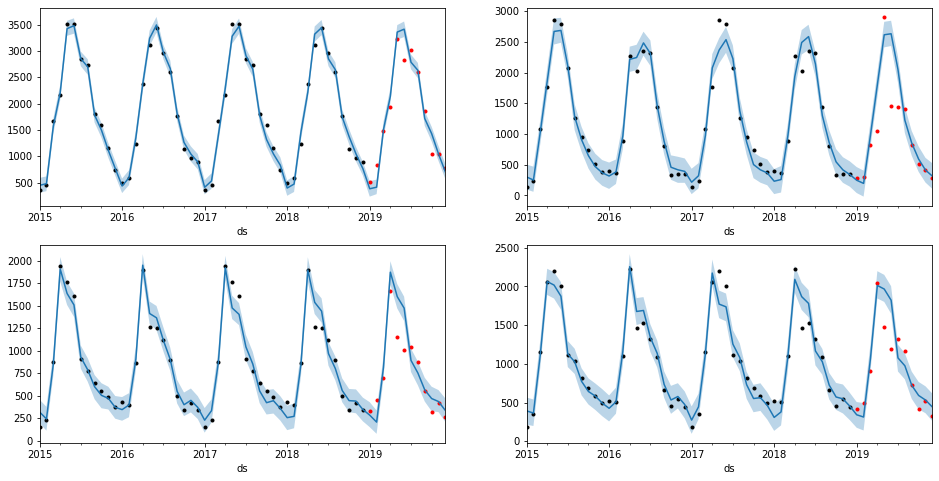

In [171]:
f, axs = plt.subplots(2, 2, figsize=(16, 8))
items = fcst_m.columns.droplevel(1).drop_duplicates()
for item, ax in zip(items, np.ravel(axs)):
    utils.plot_fcst(fcst_m[item], train=train_m[item], test=test_m[item], ax=ax)

In [180]:
fcst_m_yhat = fcst_m.loc[:, pd.IndexSlice[:, "yhat"]].droplevel(1, axis=1)

In [185]:
error = fcst_m_yhat.tail(12) - test_m

In [188]:
error.abs().mean()

16070    200.144421
16071    289.618129
44146    172.793341
44149    193.096666
dtype: float64

In [189]:
errors.abs().mean().mean()

213.91313915126793